# Dog Breed Classification with ResNet18 on AWS SageMaker

This notebook demonstrates how to fine-tune a pre-trained ResNet18 model for dog breed classification using AWS SageMaker's comprehensive ML tools.
We'll implement hyperparameter tuning, debugging, profiling, and deployment.

**Key Updates:**
- Using ResNet18 instead of ResNet50 for faster training
- Using 30% of training data for faster experimentation
- Fixed debugging configuration to avoid errors
- Consistent model architecture between HPO and training scripts

----------------------------------------------------------------------------------------------------------------------

# 1. Setup and Dependencies

In [1]:
import time
from datetime import datetime
from zoneinfo import ZoneInfo

chicago_tz = ZoneInfo('America/Chicago')
notebook_start_time = time.time()
start_datetime = datetime.now(chicago_tz)
print(f"Notebook started at: {start_datetime.strftime('%B %d, %Y at %I:%M:%S %p %Z')}")

Notebook started at: July 13, 2025 at 02:14:53 PM CDT


In [2]:
# Install required packages
!pip install smdebug

In [3]:
# Import necessary libraries
import random
import glob
from IPython.display import Image, display

import boto3
import torch
import tarfile
import tempfile
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import sagemaker
from sagemaker import image_uris

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig
)

from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

import matplotlib.pyplot as plt
from sagemaker.analytics import TrainingJobAnalytics

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Flags to control running only parts of the Notebook

In [4]:
RUN_DATA_LOADING = True  # Set to True to download the data, clean it and upload it to S3 
RUN_TUNING       = True   # Set to True to run hyperparameters tuning
RUN_TRAINING     = True  # Set to True to train the best model
DEPLOY_MODEL     = True  # Set to True to deploy the best model
DESTROY_MODEL    = False

## Initialize SageMaker Session

In [5]:
# Start a SageMaker session
sagemaker_session = sagemaker.Session()

# Get the default bucket
default_bucket = sagemaker_session.default_bucket()
s3_prefix = 'dogImages'

print(f"Using S3 bucket: {default_bucket}")

# Get execution role
execution_role = sagemaker.get_execution_role()
print(f"Execution role: {execution_role}")

Using S3 bucket: sagemaker-us-east-1-628182899181
Execution role: arn:aws:iam::628182899181:role/service-role/AmazonSageMaker-ExecutionRole-20250612T155769


----------------------------------------------------------------------------------------------------------------------

# 2. Dataset Preparation

The dog breed classification dataset contains images of 133 different dog breeds. The dataset is organized into train, validation, and test sets. We'll use 30% of the training data for faster experimentation.

In [6]:
%%time

# Download the dataset (uncomment if needed)
if RUN_DATA_LOADING:
    !wget -q https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

# CPU times: user 456 ms, sys: 76.1 ms, total: 533 ms
# Wall time: 23.1 s

CPU times: user 397 ms, sys: 177 ms, total: 574 ms
Wall time: 24.9 s


In [7]:
%%time

# Extract the dataset (uncomment if needed)
if RUN_DATA_LOADING:
    !unzip -q dogImages.zip

# CPU times: user 151 ms, sys: 64.9 ms, total: 216 ms
# Wall time: 9.02 s

CPU times: user 153 ms, sys: 79.5 ms, total: 232 ms
Wall time: 9.8 s


## Clean the Dataset

In [8]:
# Remove corrupted images that cause DataLoader errors

from PIL import Image
import os

def verify_and_fix_images(dataset_path):
    """Verify all images and fix or remove corrupted ones"""
    fixed_count = 0
    removed_count = 0
    total_count = 0
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                total_count += 1
                file_path = os.path.join(root, file)
                
                try:
                    # Try to open and verify the image
                    with Image.open(file_path) as img:
                        img.verify()
                    
                    # Try to actually load the image
                    with Image.open(file_path) as img:
                        img.convert('RGB')
                        
                except Exception as e:
                    print(f"Corrupted image: {file_path}")
                    
                    try:
                        # Try to fix by re-saving
                        with Image.open(file_path) as img:
                            rgb_img = img.convert('RGB')
                            rgb_img.save(file_path, 'JPEG')
                            fixed_count += 1
                            print(f"  Fixed by re-saving")
                    except:
                        # If can't fix, remove the file
                        os.remove(file_path)
                        removed_count += 1
                        print(f"  Removed (unfixable)")
    
    print(f"\nDataset cleaning complete:")
    print(f"Total images checked: {total_count}")
    print(f"Images fixed: {fixed_count}")
    print(f"Images removed: {removed_count}")
    print(f"Valid images: {total_count - removed_count}")

In [9]:
%%time

# Clean the dataset
if RUN_DATA_LOADING:
    verify_and_fix_images("dogImages")

Corrupted image: dogImages/train/098.Leonberger/Leonberger_06571.jpg
  Removed (unfixable)

Dataset cleaning complete:
Total images checked: 8351
Images fixed: 0
Images removed: 1
Valid images: 8350
CPU times: user 32.9 s, sys: 4.03 s, total: 36.9 s
Wall time: 38.3 s


Corrupted image: dogImages/train/098.Leonberger/Leonberger_06571.jpg
  Removed (unfixable)

Dataset cleaning complete:
Total images checked: 8351
Images fixed: 0
Images removed: 1
Valid images: 8350
CPU times: user 32.5 s, sys: 4.11 s, total: 36.6 s
Wall time: 37.3 s

## Verify Dataset After Cleaning

In [10]:
# Re-check dataset structure after cleaning

if RUN_DATA_LOADING:
    print("\nDataset after cleaning:")
    for subset in ['train', 'test', 'valid']:
        path = f"dogImages/{subset}"
        if os.path.exists(path):
            breeds = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            total_images = sum([len(os.listdir(os.path.join(path, b))) for b in breeds])
            print(f"\t{subset}: {len(breeds)} breeds, {total_images} images")


Dataset after cleaning:
	train: 133 breeds, 6679 images
	test: 133 breeds, 836 images
	valid: 133 breeds, 835 images


Dataset after cleaning:
train: 133 breeds, 6679 images
test: 133 breeds, 836 images
valid: 133 breeds, 835 images

### Upload the files to the default S3 bucket

In [11]:
%%time

# Upload the dataset to S3 (uncomment if needed)
if RUN_DATA_LOADING:
    inputs = sagemaker_session.upload_data(path='dogImages', bucket=default_bucket, key_prefix=s3_prefix)
else:
    inputs = f"s3://{default_bucket}/{s3_prefix}"

print(f"Dataset uploaded to: {inputs}")

Dataset uploaded to: s3://sagemaker-us-east-1-628182899181/dogImages
CPU times: user 48.4 s, sys: 9.96 s, total: 58.4 s
Wall time: 7min 46s


Dataset uploaded to: s3://sagemaker-us-east-1-628182899181/dogImages
CPU times: user 1min 6s, sys: 7.79 s, total: 1min 14s
Wall time: 7min 2s

----------------------------------------------------------------------------------------------------------------------

# 3. Hyperparameter Tuning

We'll tune the learning rate, batch size, and number of epochs to find the optimal configuration for our ResNet18 model.

In [12]:
hyperparameter_ranges = {
    # Learning rate: exploring a wider range
    "lr": ContinuousParameter(1e-6, 0.5),

    # Batch size: adding more options for experimentation
    "batch-size": CategoricalParameter([16, 32, 64, 128, 256]),

    # Number of epochs: allowing for longer training
    "epochs": IntegerParameter(5, 50),

    # Dropout rate: tuning regularization
    "dropout": ContinuousParameter(0.1, 0.5),

    # Optimizer: experimenting with different optimizers
    "optimizer": CategoricalParameter(["adam", "sgd", "rmsprop", "adagrad"]),

    # Weight decay: adjusting regularization strength
    "weight-decay": ContinuousParameter(1e-6, 1e-2),

    # Momentum (for optimizers like SGD)
    "momentum": ContinuousParameter(0.5, 0.99),
}

# Define objective metric
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [
    {"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"},
    {"Name": "test accuracy", "Regex": r"Test set:.*\((\d+)%\)"},
    {"Name": "train loss", "Regex": r"Loss: ([0-9]+\.[0-9]+)"},
    {"Name": "train accuracy", "Regex": r"Accuracy: \d+/\d+ \((\d+)%\)"}
]

In [13]:
# Create PyTorch estimator for hyperparameter tuning
estimator_hpo = PyTorch(
    entry_point="hpo.py",
    role=execution_role,
    py_version='py38',
    framework_version="1.12",
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    hyperparameters={
        "data_pct": 1.0  # 1.0 for 100%
    },
    metric_definitions=metric_definitions,
    # disable_profiler=True,  # Disable profiler for HPO to reduce overhead
    use_spot_instances=True,  # Enable spot instances
    max_wait=3600,  # Maximum wait time for spot instances (in seconds)
    max_run=3600,  # Maximum runtime for the training job
)

max_jobs = 20
max_parallel_jobs = 4

# Create HyperparameterTuner
tuner = HyperparameterTuner(
    estimator_hpo,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=max_jobs,
    max_parallel_jobs=max_parallel_jobs,
    objective_type=objective_type,
    early_stopping_type='Auto'
)

In [14]:
%%time

if RUN_TUNING:
    # Start hyperparameter tuning job
    tuner.fit({'training': inputs}, logs=True, wait=True)
    print(f"Tuning job name: {tuner.latest_tuning_job.name}")

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................................................................................................................................................................!
Tuning job name: pytorch-training-250713-1924
CPU times: user 1.65 s, sys: 174 ms, total: 1.82 s
Wall time: 29min 12s


## Retrieve Best Hyperparameters

In [15]:
if RUN_TUNING:
    # Get the best training job
    best_training_job = tuner.best_training_job()
    print(f"Best training job: {best_training_job}")

    # Get the hyperparameters and clean them
    best_hyperparameters = tuner.best_estimator().hyperparameters()
    print(f"Raw hyperparameters: {best_hyperparameters}")

    # Function to clean hyperparameter values
    def clean_hyperparameter(value):
        """Remove extra quotes and convert to appropriate type"""
        if isinstance(value, str):
            # Remove quotes if present
            value = value.strip('"').strip("'")
        return value

    # Clean and convert hyperparameters
    cleaned_hyperparameters = {
        'epochs': int(clean_hyperparameter(best_hyperparameters.get('epochs', '3'))),
        'batch-size': int(clean_hyperparameter(best_hyperparameters.get('batch-size', '64'))),
        'lr': float(clean_hyperparameter(best_hyperparameters.get('lr', '0.001'))),
        'dropout': float(clean_hyperparameter(best_hyperparameters.get('dropout', '0.01'))),
        'optimizer': clean_hyperparameter(best_hyperparameters.get('optimizer', 'adam')),
        'weight-decay': float(clean_hyperparameter(best_hyperparameters.get('weight-decay', '1e-6'))),
        'momentum': float(clean_hyperparameter(best_hyperparameters.get('momentum', '0.5'))),
        'data_pct': float(clean_hyperparameter(best_hyperparameters.get('data_pct', '0.3')))
    }

    print(f"Cleaned hyperparameters: {cleaned_hyperparameters}")

Best training job: pytorch-training-250713-1924-013-e4df71bc

2025-07-13 19:44:21 Starting - Preparing the instances for training
2025-07-13 19:44:21 Downloading - Downloading the training image
2025-07-13 19:44:21 Training - Training image download completed. Training in progress.
2025-07-13 19:44:21 Uploading - Uploading generated training model
2025-07-13 19:44:21 Completed - Training job completed
Raw hyperparameters: {'_tuning_objective_metric': '"average test loss"', 'batch-size': '"64"', 'data_pct': '1.0', 'dropout': '0.5', 'epochs': '48', 'lr': '0.0009835750223782652', 'momentum': '0.99', 'optimizer': '"sgd"', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2025-07-13-19-24-00-486"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-628182899181/pytorch-training-20

In [16]:

# After tuning completes, save the results
def save_tuning_results(tuner, cleaned_hyperparameters, filename_prefix="tuning_results"):
    """Save tuning results to files for later use"""
    
    # Save the cleaned hyperparameters
    with open(f"{filename_prefix}_hyperparameters.json", "w") as f:
        json.dump(cleaned_hyperparameters, f, indent=2)
    
    # Get the objective metric value from the best training job
    best_job_name = tuner.best_training_job()
    
    # Get the tuning job description to find the objective metric value
    try:
        describe_response = tuner.sagemaker_session.sagemaker_client.describe_hyper_parameter_tuning_job(
            HyperParameterTuningJobName=tuner.latest_tuning_job.name
        )
        
        # Find the best training job's metric
        objective_metric_value = None
        if 'BestTrainingJob' in describe_response:
            objective_metric_value = describe_response['BestTrainingJob'].get('FinalHyperParameterTuningJobObjectiveMetric', {}).get('Value')
    except:
        objective_metric_value = None
    
    # Save tuning job name and best training job name
    tuning_metadata = {
        "tuning_job_name": tuner.latest_tuning_job.name,
        "best_training_job": best_job_name,
        "objective_metric_value": objective_metric_value
    }
    
    with open(f"{filename_prefix}_metadata.json", "w") as f:
        json.dump(tuning_metadata, f, indent=2)
    
    print(f"Tuning results saved to {filename_prefix}_hyperparameters.json and {filename_prefix}_metadata.json")
    if objective_metric_value:
        print(f"Best objective metric value: {objective_metric_value}")
    return tuning_metadata


# Load saved hyperparameters (use this to skip tuning)
def load_tuning_results(filename_prefix="tuning_results"):
    """Load previously saved tuning results"""
    
    # Load hyperparameters
    with open(f"{filename_prefix}_hyperparameters.json", "r") as f:
        cleaned_hyperparameters = json.load(f)
    
    # Load metadata
    with open(f"{filename_prefix}_metadata.json", "r") as f:
        tuning_metadata = json.load(f)
    
    print("Loaded hyperparameters:")
    print(json.dumps(cleaned_hyperparameters, indent=2))
    print(f"\nFrom tuning job: {tuning_metadata['tuning_job_name']}")
    print(f"Best training job: {tuning_metadata['best_training_job']}")
    
    return cleaned_hyperparameters, tuning_metadata

In [17]:
if RUN_TUNING:
    tuning_metadata = save_tuning_results(tuner, cleaned_hyperparameters)
else:
    # Load saved hyperparameters
    cleaned_hyperparameters, tuning_metadata = load_tuning_results()

print(json.dumps(cleaned_hyperparameters, indent=2))

Tuning results saved to tuning_results_hyperparameters.json and tuning_results_metadata.json
Best objective metric value: 0.6394000053405762
{
  "epochs": 48,
  "batch-size": 64,
  "lr": 0.0009835750223782652,
  "dropout": 0.5,
  "optimizer": "sgd",
  "weight-decay": 5.533780431558222e-06,
  "momentum": 0.99,
  "data_pct": 1.0
}


----------------------------------------------------------------------------------------------------------------------

# 4. Model Training with Debugging and Profiling

Using the best hyperparameters, we'll train a new model with debugging and profiling enabled to monitor training performance.

### Set up Debugging Rules and Hooks

In [18]:
# Import necessary debugging components
from sagemaker.debugger import Rule, DebuggerHookConfig, CollectionConfig, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

debugger_hook_config = DebuggerHookConfig(
    s3_output_path=f"s3://{default_bucket}/sagemaker-debugger",
    collection_configs=[
        # CollectionConfig(name="weights",   parameters={"save_interval": "100"}),
        # CollectionConfig(name="gradients", parameters={"save_interval": "100"}),
        # CollectionConfig(name="losses",    parameters={"save_interval": "10"}),
        # CollectionConfig(name="metrics",   parameters={"save_interval": "10"}),
    ]
)

# Define profiler configuration
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(
        num_steps=50
    )
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Create and Train Model with Best Hyperparameters

In [19]:
instance_type_for_training = "ml.g4dn.4xlarge"

image_uri = image_uris.retrieve(
    framework='pytorch',
    region=boto3.Session().region_name,
    version='1.12.0',
    py_version='py38',
    instance_type=instance_type_for_training,
    image_scope='training'
)
print("Official PyTorch DLC URI:", image_uri)

Official PyTorch DLC URI: 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.12.0-gpu-py38


In [20]:

# define how to pull metrics out of your log lines
metric_definitions = [
    {
        "Name": "train:loss",
        "Regex": r"Loss: ([0-9]+\.[0-9]+)"
    },
    {
        "Name": "train:accuracy",
        "Regex": r"Accuracy: \d+/\d+ \((\d+)%\)"
    },
    {
        "Name": "validation:loss",
        "Regex": r"Test set: Average loss: ([0-9]+\.[0-9]+)"
    },
    {
        "Name": "validation:accuracy",
        "Regex": r"Test set:.*\((\d+)%\)"
    },
]

estimator = PyTorch(
    entry_point="train_model.py",
    source_dir=".",
    role=execution_role,
    framework_version="1.12",
    py_version="py38",
    instance_count=1,
    instance_type=instance_type_for_training,
    image_uri=image_uri,
    hyperparameters=cleaned_hyperparameters,
    debugger_hook_config=debugger_hook_config,
    rules=rules,
    profiler_config=profiler_config,
    metric_definitions=metric_definitions,
    volume_size=30,
    max_run=3600
)

# "ml.g4dn.4xlarge"      $1.204 On Demand     $0.3973 Spot


In [21]:
# After training completes, save the training information
def save_training_results(estimator, filename_prefix="training_results"):
    """Save training job information for later use"""

    training_info = {
        "training_job_name": estimator.latest_training_job.name,
        "model_data": estimator.model_data,
        "hyperparameters": estimator.hyperparameters(),
        "instance_type": estimator.instance_type,
        "framework_version": estimator.framework_version,
        "py_version": estimator.py_version,
        "image_uri": estimator.image_uri,
        "role": estimator.role,
        "output_path": estimator.output_path,
        "code_location": estimator.code_location,
        "debugger_s3_output_path": f"s3://{default_bucket}/sagemaker-debugger/{estimator.latest_training_job.name}"
    }

    with open(f"{filename_prefix}.json", "w") as f:
        json.dump(training_info, f, indent=2)

    print(f"Training results saved to {filename_prefix}.json")
    print(f"Model data location: {training_info['model_data']}")
    return training_info


# Load saved training results and create model
def load_training_results_and_create_model(filename_prefix="training_results"):
    """Load training results and create a deployable model"""

    with open(f"{filename_prefix}.json", "r") as f:
        training_info = json.load(f)

    print(f"Loaded training job: {training_info['training_job_name']}")
    print(f"Model data: {training_info['model_data']}")

    # Create a PyTorchModel from the saved model artifacts
    from sagemaker.pytorch import PyTorchModel

    model = PyTorchModel(
        model_data=training_info['model_data'],
        role=training_info['role'],
        framework_version=training_info['framework_version'],
        py_version=training_info['py_version'],
        entry_point='inference.py',
        sagemaker_session=sagemaker_session
    )

    return model, training_info

In [22]:
%%time

if RUN_TRAINING:
    # Start training
    print("Starting training with debugging and profiling...")
    estimator.fit({'training': inputs}, wait=True, logs=True)
    training_info = save_training_results(estimator)
else:
    # Load saved model
    model, training_info = load_training_results_and_create_model()

Starting training with debugging and profiling...


INFO:sagemaker:Creating training-job with name: pytorch-training-2025-07-13-19-53-18-852


2025-07-13 19:54:49 Starting - Starting the training job...
2025-07-13 19:55:16 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
...
2025-07-13 19:55:36 Downloading - Downloading input data...
2025-07-13 19:56:16 Downloading - Downloading the training image...............
2025-07-13 19:58:37 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-07-13 19:59:06,002 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-07-13 19:59:06,030 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-07-13 19:59:06,032 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-07-13 19:59:20,718 sagemaker-training-toolkit INFO     Invoking user script
Traini

## Analyze Debugging Output

In [23]:
if RUN_TRAINING:
    # Get training job name
    training_job_name = estimator.latest_training_job.name
    print(f"Training job name: {training_job_name}")

    # Check debugging rule status
    for rule in estimator.latest_training_job.rule_job_summary():
        print(f"Rule: {rule['RuleConfigurationName']}")
        print(f"Status: {rule['RuleEvaluationStatus']}")
        print(f"Status Details: {rule.get('StatusDetails', 'N/A')}\n")
else:
    training_job_name = training_info.get('training_job_name')
    print(f"Found training job name: {job_name}")
    # Attach to the existing training job
    estimator = PyTorch.attach(training_job_name)

Training job name: pytorch-training-2025-07-13-19-53-18-852
Rule: VanishingGradient
Status: InProgress
Status Details: N/A

Rule: Overfit
Status: InProgress
Status Details: N/A

Rule: Overtraining
Status: InProgress
Status Details: N/A

Rule: PoorWeightInitialization
Status: IssuesFound
Status Details: RuleEvaluationConditionMet: Evaluation of the rule PoorWeightInitialization at step 0 resulted in the condition being met




In [24]:
# Try to analyze debugging output
try:
    from smdebug.trials import create_trial
    
    # Create trial from the training job
    s3_output_path = f"s3://{default_bucket}/sagemaker-debugger/{training_job_name}/debug-output"
    trial = create_trial(s3_output_path)
    
    # Get available tensors
    print("Available tensors:")
    for tensor_name in trial.tensor_names():
        print(f"  - {tensor_name}")
        
except Exception as e:
    print(f"Could not load debugging data: {e}")
    print("This is normal if debugging was disabled or no data was saved.")

[2025-07-13 20:13:22.061 default:4559 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-07-13 20:13:22.146 default:4559 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-628182899181/sagemaker-debugger/pytorch-training-2025-07-13-19-53-18-852/debug-output
Available tensors:
[2025-07-13 20:13:22.726 default:4559 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-07-13 20:13:23.744 default:4559 INFO trial.py:210] Loaded all steps
  - CrossEntropyLoss_output_0
  - gradient/ResNet_fc.1.bias
  - gradient/ResNet_fc.1.weight
  - gradient/ResNet_layer3.1.bn1.bias
  - gradient/ResNet_layer3.1.bn1.weight
  - gradient/ResNet_layer3.1.bn2.bias
  - gradient/ResNet_layer3.1.bn2.weight
  - gradient/ResNet_layer3.1.conv1.weight
  - gradient/ResNet_layer3.1.conv2.weight
  - gradient/ResNet_layer4.0.bn1.bias
  - gradient/ResNet_layer4.0.bn1.weight
  - gradient/ResNet_layer4.0.bn2.bias
  - gradient/ResNet_layer4.0.bn2.weight
  - gra

In [25]:
def plot_training_metrics(estimator):
    """Fetches loss & accuracy from CloudWatch via SageMaker Analytics and plots them."""
    # grab the job name
    job_name = estimator.latest_training_job.job_name

    # metrics you logged in your script
    metric_names = [
        "train:loss",       # training loss logged per step
        "validation:loss",  # validation loss (if you logged it in your training script)
        "train:accuracy",   # training accuracy (if logged)
        "validation:accuracy"
    ]

    # pull all metric streams into a DataFrame
    analytics = TrainingJobAnalytics(
        training_job_name=job_name,
        metric_names=metric_names
    )
    df = analytics.dataframe()  # cols: metric_name, value, timestamp, step

    # If 'step' column is missing, create a synthetic step for plotting.
    if 'step' not in df.columns:
        df = df.sort_values('timestamp')
        df['step'] = df.groupby('metric_name').cumcount() + 1
    
    # pivot to wide form: index=step, columns=metric_name
    pivot = df.pivot(index="step", columns="metric_name", values="value")

    # Plot Loss
    plt.figure()
    for col in ["train:loss", "validation:loss"]:
        if col in pivot:
            plt.plot(pivot.index, pivot[col], label=col)
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title(f"Training vs. Validation Loss ({job_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy
    plt.figure()
    for col in ["train:accuracy", "validation:accuracy"]:
        if col in pivot:
            plt.plot(pivot.index, pivot[col], label=col)
    plt.xlabel("Step")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Training vs. Validation Accuracy ({job_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

    return df


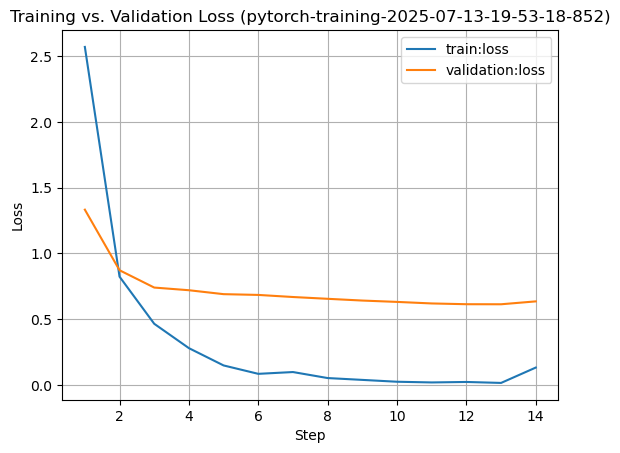

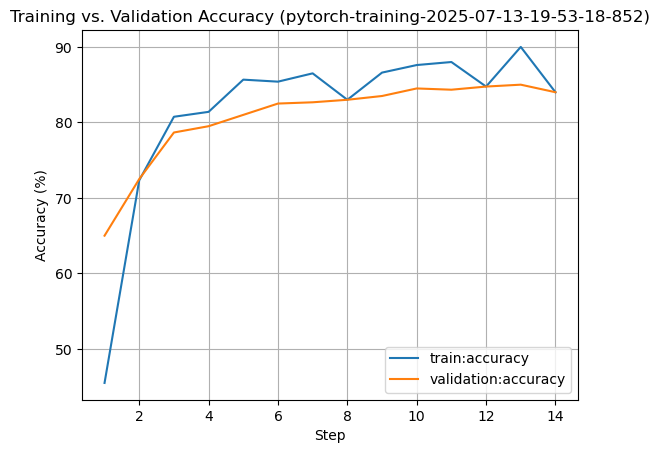

In [26]:
df = plot_training_metrics(estimator)

In [27]:
df.head(10)

,timestamp,metric_name,value,step
0,0.0,train:loss,2.569534,1
14,0.0,validation:loss,1.331800,1
28,0.0,train:accuracy,45.500000,1
42,0.0,validation:accuracy,65.000000,1
29,60.0,train:accuracy,72.333333,2
1,60.0,train:loss,0.822267,2
43,60.0,validation:accuracy,72.500000,2
15,60.0,validation:loss,0.871075,2
30,120.0,train:accuracy,80.750000,3
44,120.0,validation:accuracy,78.666667,3


## Common Debugging Scenarios

**Potential issues that debugging can catch:**
1. **Vanishing Gradients**: If gradients become too small, the model stops learning
2. **Overfitting**: Model performs well on training data but poorly on validation
3. **Poor Weight Initialization**: Starting weights that prevent effective learning
4. **Overtraining**: Training for too long without improvement

**How to fix these issues:**
- Vanishing gradients: Use different activation functions, adjust learning rate, or use batch normalization
- Overfitting: Add dropout, use data augmentation, or reduce model complexity
- Poor initialization: Use different initialization methods (Xavier, He initialization)
- Overtraining: Implement early stopping or reduce number of epochs

## Model Deployment

Inspect the model to make sure it was saved properly.

In [28]:
def inspect_model_artifacts_fixed(model_data_s3_path):
    """Download and inspect the model artifacts from S3"""
    
    # Parse S3 path
    s3_path = model_data_s3_path.replace('s3://', '')
    bucket, key = s3_path.split('/', 1)
    
    print(f"Downloading model from s3://{bucket}/{key}")
    
    # Download the model.tar.gz file
    s3_client = boto3.client('s3')
    
    with tempfile.TemporaryDirectory() as temp_dir:
        local_file = os.path.join(temp_dir, 'model.tar.gz')
        s3_client.download_file(bucket, key, local_file)
        
        # Extract the tar.gz file
        extract_dir = os.path.join(temp_dir, 'extracted')
        os.makedirs(extract_dir)
        
        with tarfile.open(local_file, 'r:gz') as tar:
            tar.extractall(extract_dir)
        
        # List contents
        print("Model artifact contents:")
        for root, dirs, files in os.walk(extract_dir):
            for file in files:
                file_path = os.path.join(root, file)
                rel_path = os.path.relpath(file_path, extract_dir)
                print(f"  {rel_path}")
        
        # Try to load and inspect model.pth if it exists
        model_pth_path = os.path.join(extract_dir, 'model.pth')
        if os.path.exists(model_pth_path):
            print(f"\nInspecting model.pth:")
            try:
                # Use weights_only=False to handle the argparse.Namespace issue
                saved_data = torch.load(model_pth_path, map_location='cpu', weights_only=False)

                if isinstance(saved_data, dict):
                    print(f"Top-level keys: {list(saved_data.keys())}")

                    if 'model_state_dict' in saved_data:
                        model_state = saved_data['model_state_dict']
                        print(f"Model state dict keys (first 10): {list(model_state.keys())[:10]}")

                        # Check if it's a complete model
                        has_backbone = any('conv1' in key or 'layer1' in key for key in model_state.keys())
                        print(f"Has backbone layers: {has_backbone}")

                        if 'fc.weight' in model_state:
                            print(f"Number of classes: {model_state['fc.weight'].shape[0]}")

                    if 'hyperparameters' in saved_data:
                        # print(f"Hyperparameters: {saved_data['hyperparameters']}")
                        print(f"\nHyperparameters: {json.dumps(saved_data['hyperparameters'], indent=2)}\n")

                    if 'args' in saved_data:
                        print(f"Args: {saved_data['args']}")
                else:
                    # Direct state dict
                    print(f"Direct state dict keys (first 10): {list(saved_data.keys())[:10]}")
                    has_backbone = any('conv1' in key or 'layer1' in key for key in saved_data.keys())
                    print(f"Has backbone layers: {has_backbone}")

                    if 'fc.weight' in saved_data:
                        print(f"Number of classes: {saved_data['fc.weight'].shape[0]}")

            except Exception as e:
                print(f"Error loading model.pth: {e}")
        else:
            print("No model.pth found in artifacts")


# Inspect the model artifacts with the fixed function
inspect_model_artifacts_fixed(training_info['model_data'])

/tmp/ipykernel_4559/559620333.py:22: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_dir)


Model artifact contents:
  model.pt
  model.pth
  checkpoint.pth

Inspecting model.pth:
Top-level keys: ['model_state_dict', 'test_accuracy', 'test_loss', 'hyperparameters', 'args']
Model state dict keys (first 10): ['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean']
Has backbone layers: True

Hyperparameters: {
  "epochs": 48,
  "batch_size": 64,
  "lr": 0.0009835750223782652,
  "dropout": 0.5,
  "momentum": 0.99,
  "optimizer": "sgd",
  "weight_decay": 5.533780431558222e-06,
  "data_pct": 1.0
}

Args: Namespace(batch_size=64, epochs=48, lr=0.0009835750223782652, dropout=0.5, momentum=0.99, optimizer='sgd', weight_decay=5.533780431558222e-06, data_pct=1.0, use_amp=True, auto_lr=True, model_dir='/opt/ml/model', data_dir='/opt/ml/input/data/training', num_gpus=1, output_dir='/opt/ml/output/data')


In [29]:
# Create inference script
inference_code = '''
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
import json
import io
from PIL import Image
import os
import logging

logger = logging.getLogger(__name__)

def model_fn(model_dir):
    """Load the model for inference"""
    logger.info(f"Loading model from {model_dir}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")
    
    # Load the trained model weights first to inspect what's saved
    model_path = os.path.join(model_dir, "model.pth")
    logger.info(f"Loading model weights from {model_path}")
    
    try:
        # Try loading with weights_only=False for newer PyTorch versions
        try:
            saved_data = torch.load(model_path, map_location=device, weights_only=False)
        except TypeError:
            # Fall back to old torch.load for older PyTorch versions
            saved_data = torch.load(model_path, map_location=device)
        
        logger.info(f"Saved data keys: {list(saved_data.keys())}")
        
        # Extract the actual model state dict
        if 'model_state_dict' in saved_data:
            state_dict = saved_data['model_state_dict']
            logger.info("Found model_state_dict")
        elif 'state_dict' in saved_data:
            state_dict = saved_data['state_dict']
            logger.info("Found state_dict")
        else:
            # Assume the entire saved_data is the state_dict
            state_dict = saved_data
            logger.info("Using entire saved data as state_dict")
        
        logger.info(f"Model state dict keys: {list(state_dict.keys())[:10]}...")
        
        # Check if this is a complete model or just the classifier
        has_backbone = any('conv1' in key or 'layer1' in key for key in state_dict.keys())
        
        if has_backbone:
            # Complete model - load normally
            logger.info("Complete model detected")
            model = resnet18(pretrained=False)
            
            # Check if the model uses Sequential fc layer or simple Linear
            has_sequential_fc = any('fc.1.weight' in key for key in state_dict.keys())
            
            if has_sequential_fc:
                # Model has Sequential fc layer (with dropout)
                logger.info("Sequential FC layer detected")
                num_classes = state_dict['fc.1.weight'].shape[0]
                
                # Get dropout value from hyperparameters if available
                dropout_rate = 0.25  # default
                if 'hyperparameters' in saved_data and 'dropout' in saved_data['hyperparameters']:
                    dropout_rate = saved_data['hyperparameters']['dropout']
                    logger.info(f"Using dropout rate from hyperparameters: {dropout_rate}")
                
                # Create Sequential fc layer to match the saved model
                model.fc = nn.Sequential(
                    nn.Dropout(dropout_rate),
                    nn.Linear(model.fc.in_features, num_classes)
                )
                logger.info(f"Created Sequential fc with dropout={dropout_rate}, num_classes={num_classes}")
                
            else:
                # Standard Linear fc layer
                logger.info("Standard Linear FC layer detected")
                if 'fc.weight' in state_dict:
                    num_classes = state_dict['fc.weight'].shape[0]
                else:
                    num_classes = 133  # default
                model.fc = nn.Linear(model.fc.in_features, num_classes)
                logger.info(f"Created Linear fc with num_classes={num_classes}")
            
            # Load the complete state dict
            try:
                model.load_state_dict(state_dict)
                logger.info("Successfully loaded complete model state dict")
            except Exception as load_error:
                logger.error(f"Error loading state dict: {load_error}")
                # Print available keys for debugging
                logger.info(f"Available state dict keys: {list(state_dict.keys())}")
                logger.info(f"Model keys: {list(model.state_dict().keys())}")
                raise load_error
        else:
            # Only classifier saved - use pretrained backbone
            logger.info("Only classifier detected - using pretrained backbone")
            model = resnet18(pretrained=True)  # Use pretrained backbone
            
            # Try to get num_classes from hyperparameters first
            num_classes = 2  # default
            if 'hyperparameters' in saved_data:
                hyperparams = saved_data['hyperparameters']
                logger.info(f"Hyperparameters: {hyperparams}")
                if 'num_classes' in hyperparams:
                    num_classes = hyperparams['num_classes']
                elif 'n_classes' in hyperparams:
                    num_classes = hyperparams['n_classes']
            
            # Try to infer from classifier weights
            if 'fc.weight' in state_dict:
                num_classes = state_dict['fc.weight'].shape[0]
            elif 'weight' in state_dict:
                num_classes = state_dict['weight'].shape[0]
                
            logger.info(f"Number of classes: {num_classes}")
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            
            # Load only the classifier weights
            if 'fc.weight' in state_dict and 'fc.bias' in state_dict:
                fc_state_dict = {'weight': state_dict['fc.weight'], 'bias': state_dict['fc.bias']}
                model.fc.load_state_dict(fc_state_dict)
                logger.info("Loaded fc weights from fc.weight and fc.bias")
            elif 'weight' in state_dict and 'bias' in state_dict:
                fc_state_dict = {'weight': state_dict['weight'], 'bias': state_dict['bias']}
                model.fc.load_state_dict(fc_state_dict)
                logger.info("Loaded fc weights from weight and bias")
            else:
                logger.error(f"Cannot load classifier weights. Available keys: {list(state_dict.keys())}")
                raise ValueError("Cannot load classifier weights")
        
        logger.info("Model weights loaded successfully")
        
    except Exception as e:
        logger.error(f"Error loading model weights: {e}")
        raise e
    
    model.to(device)
    model.eval()
    
    return model

def input_fn(request_body, content_type='application/x-image'):
    """Parse input data for inference"""
    logger.info(f"Processing input with content_type: {content_type}")
    
    if content_type == 'application/x-image':
        try:
            # Handle image input
            image = Image.open(io.BytesIO(request_body)).convert('RGB')
            logger.info(f"Image loaded successfully, size: {image.size}")
            return image
        except Exception as e:
            logger.error(f"Error processing image: {e}")
            raise e
    else:
        raise ValueError(f"Unsupported content type: {content_type}")

def predict_fn(input_data, model):
    """Run prediction on the input data"""
    logger.info("Running prediction")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Define the same transforms used during training
    # Adjust these if your training used different transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    try:
        # Transform the input image
        input_tensor = transform(input_data).unsqueeze(0).to(device)
        logger.info(f"Input tensor shape: {input_tensor.shape}")
        
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
        
        logger.info(f"Prediction completed: class={predicted_class}, confidence={confidence}")
        
        return {
            'predicted_class': predicted_class,
            'confidence': confidence,
            'probabilities': probabilities.cpu().numpy().tolist()[0]
        }
        
    except Exception as e:
        logger.error(f"Error during prediction: {e}")
        raise e

def output_fn(prediction, accept='application/json'):
    """Format the prediction output"""
    logger.info(f"Formatting output with accept: {accept}")
    
    if accept == 'application/json':
        return json.dumps(prediction), accept
    else:
        raise ValueError(f"Unsupported accept type: {accept}")
'''

# Save inference script
with open('inference.py', 'w') as f:
    f.write(inference_code)

print("Inference script created successfully!")

Inference script created successfully!


In [30]:
%%time

if DEPLOY_MODEL:
    # After training is complete, create a PyTorch model
    pytorch_model = PyTorchModel(
        model_data=estimator.model_data,  # S3 path to the model artifacts
        role=execution_role,              # SageMaker execution role
        entry_point='inference.py',       # Inference script
        framework_version='1.12',         # PyTorch version
        py_version='py38'
    )
    
    # Deploy the model
    predictor = pytorch_model.deploy(
        initial_instance_count=1,
        instance_type="ml.m5.2xlarge",
        serializer=sagemaker.serializers.IdentitySerializer(
            content_type="application/x-image"
        ),
        deserializer=sagemaker.deserializers.JSONDeserializer(),
    )

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-628182899181/pytorch-training-2025-07-13-19-53-18-852/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-628182899181/pytorch-inference-2025-07-13-20-13-26-877/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2025-07-13-20-13-39-583
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2025-07-13-20-13-40-248
INFO:sagemaker:Creating endpoint with name pytorch-inference-2025-07-13-20-13-40-248


------!CPU times: user 11.8 s, sys: 1.39 s, total: 13.2 s
Wall time: 3min 44s


## Test the Deployed Model

File: dogImages/test/082.Havanese/Havanese_05576.jpg
 → Predicted class: 81
 → Confidence: 0.9986


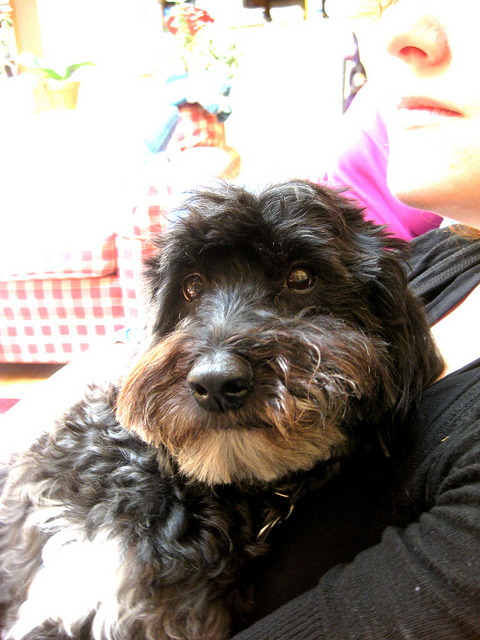

------------------------------------------------------------

File: dogImages/test/058.Dandie_dinmont_terrier/Dandie_dinmont_terrier_04131.jpg
 → Predicted class: 57
 → Confidence: 1.0000


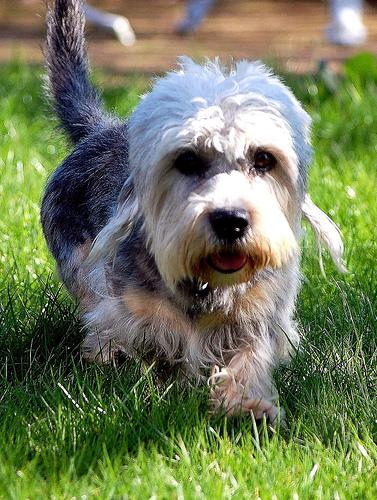

------------------------------------------------------------

File: dogImages/test/020.Belgian_malinois/Belgian_malinois_01471.jpg
 → Predicted class: 19
 → Confidence: 1.0000


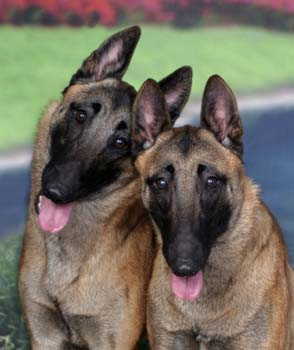

------------------------------------------------------------

File: dogImages/test/082.Havanese/Havanese_05566.jpg
 → Predicted class: 81
 → Confidence: 0.9952


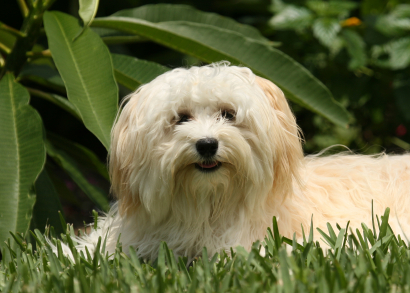

------------------------------------------------------------

File: dogImages/test/101.Maltese/Maltese_06728.jpg
 → Predicted class: 100
 → Confidence: 0.9915


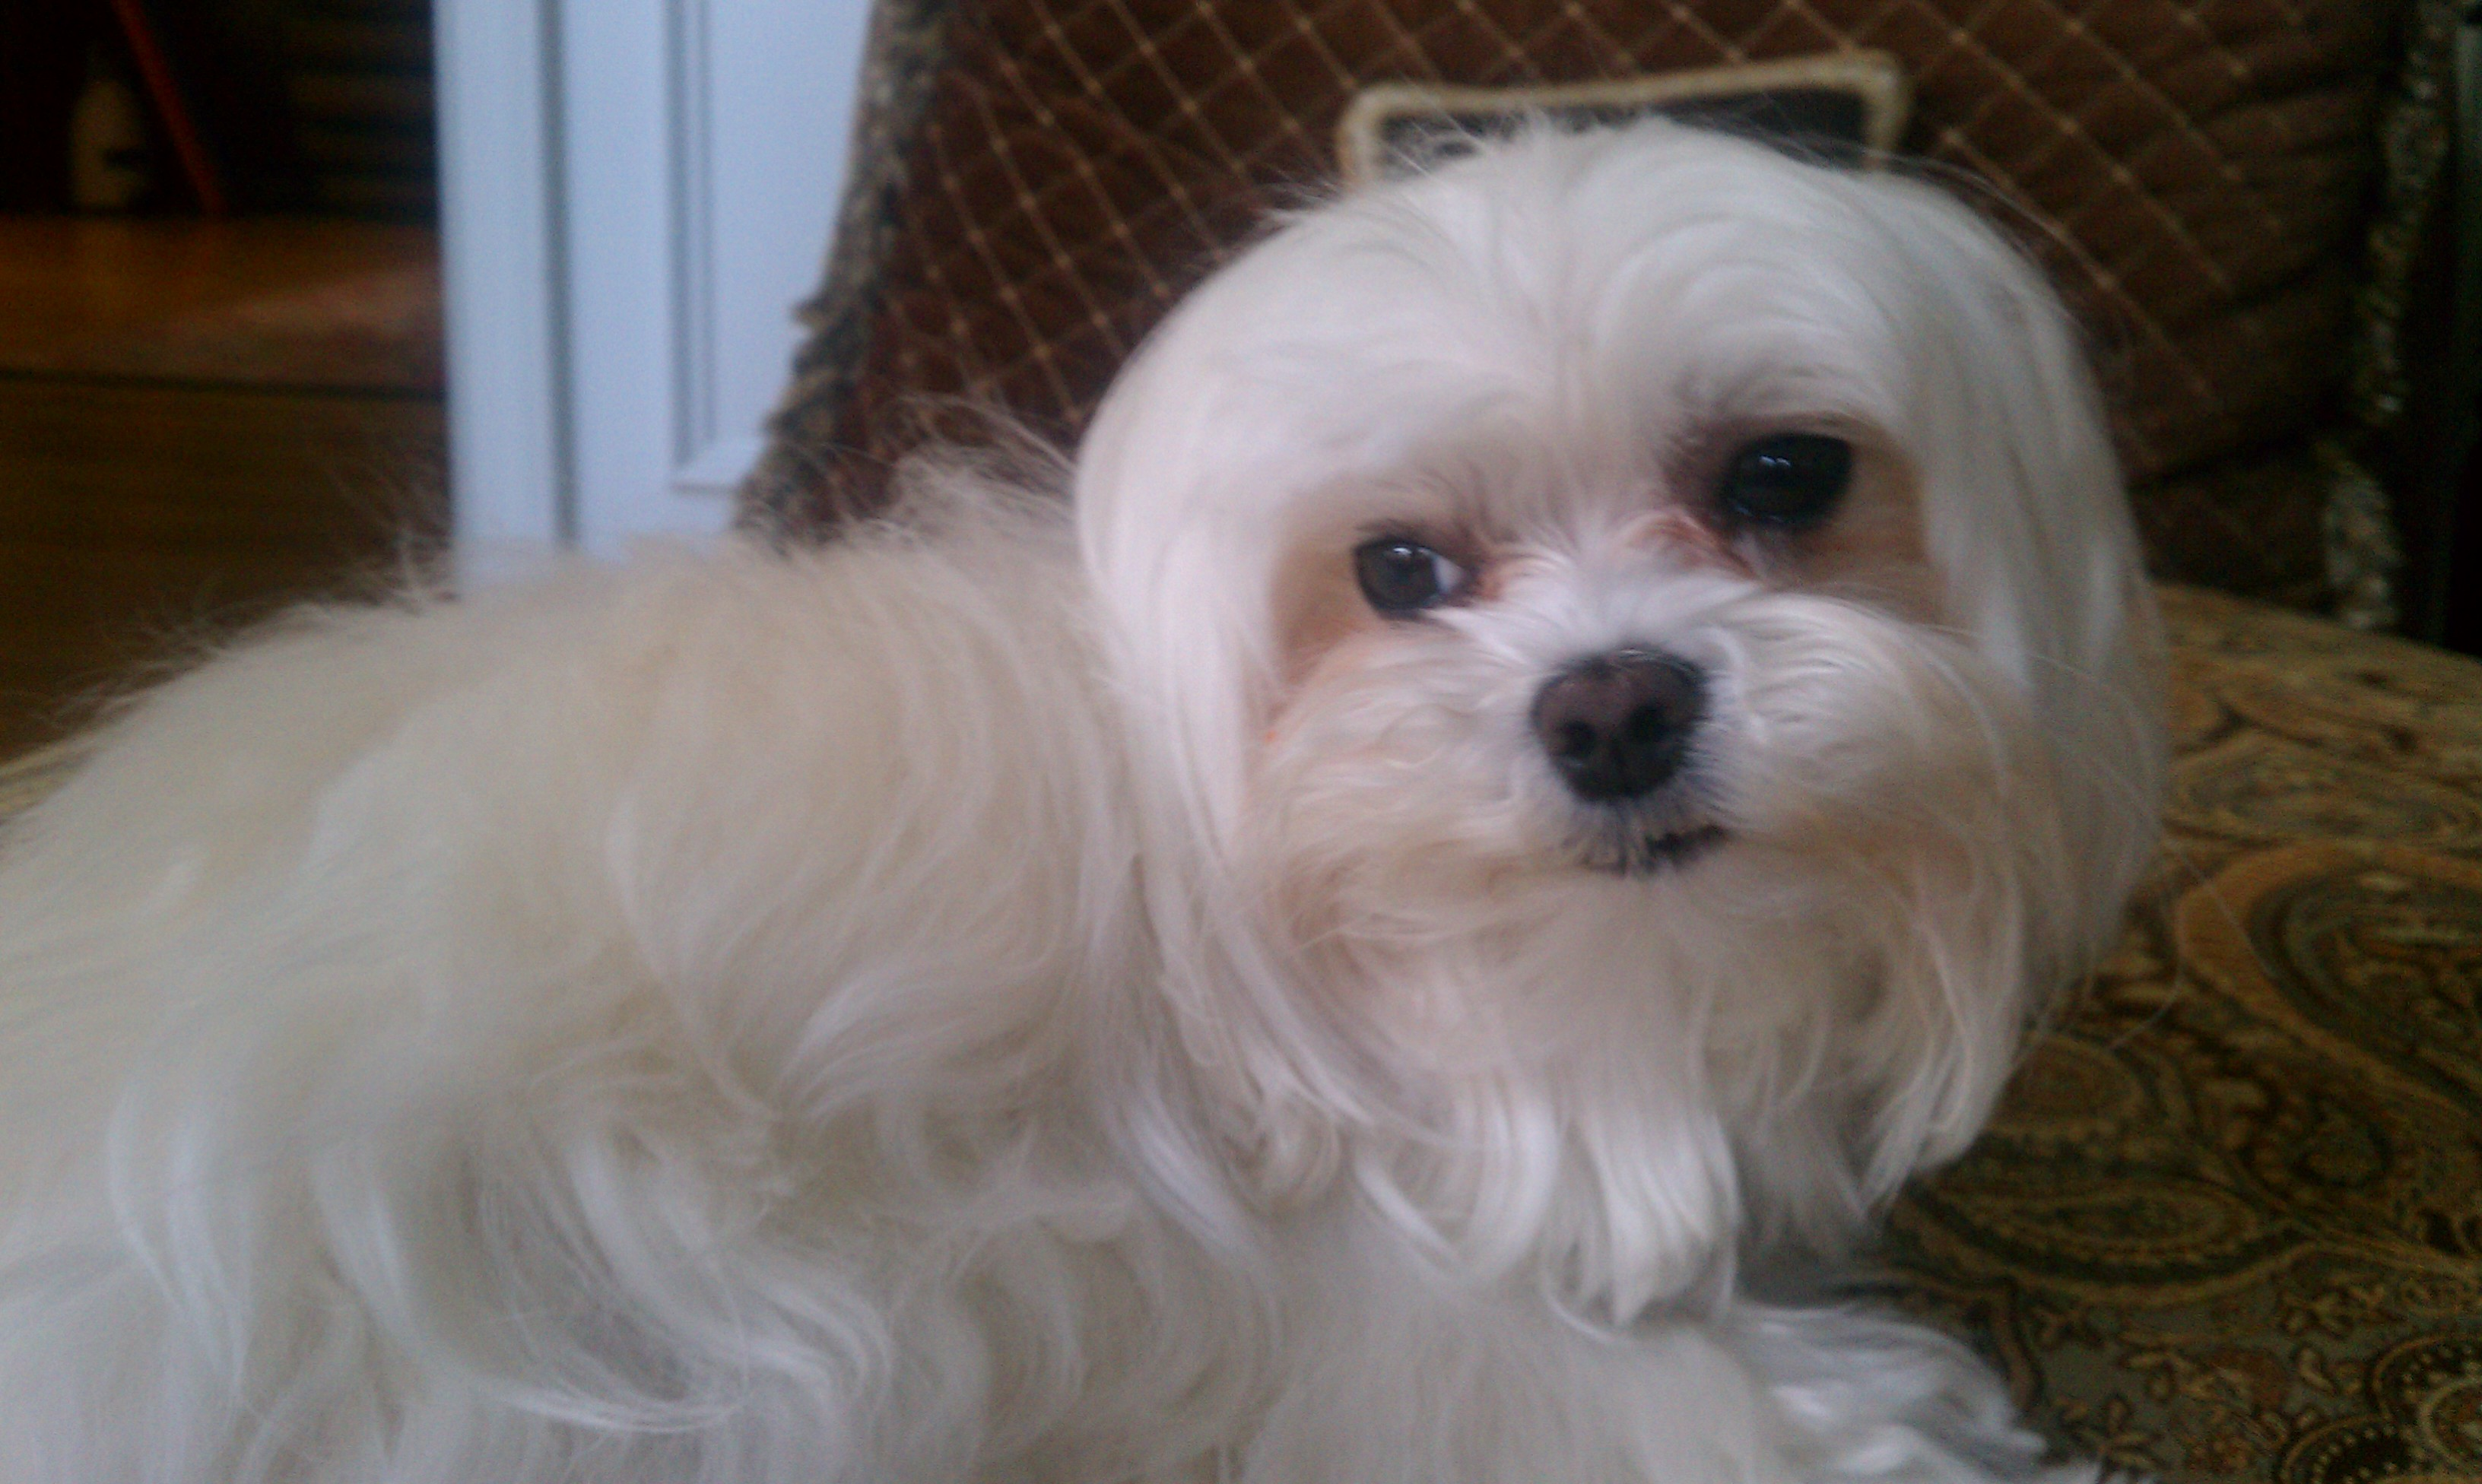

------------------------------------------------------------



In [32]:
import glob
import random
from IPython.display import display, Image

if DEPLOY_MODEL:
    # Gather all JPEG paths under the test folder
    test_image_paths = glob.glob("dogImages/test/**/*.jpg", recursive=True)
    # Randomly select 5 images
    sample_paths = random.sample(test_image_paths, 5)
    
    for img_path in sample_paths:
        # Read image bytes
        with open(img_path, 'rb') as f:
            image_bytes = f.read()
        
        # Call the endpoint
        response = predictor.predict(image_bytes)
        predicted_class = response.get('predicted_class', 'N/A')
        confidence = response.get('confidence', 0.0)
        
        # Print out results
        print(f"File: {img_path}")
        print(f" → Predicted class: {predicted_class}")
        print(f" → Confidence: {confidence:.4f}")  # Show more decimal places for confidence
        
        # Display the image correctly
        display(Image(filename=img_path))  # Use filename parameter
        print("-" * 60 + "\n")

In [33]:
notebook_end_time = time.time()
end_datetime = datetime.now(chicago_tz)
total_time = notebook_end_time - notebook_start_time

print(f"\nNotebook Execution Summary")
print(f"{'='*40}")
print(f"Started:  {start_datetime.strftime('%I:%M:%S %p %Z')}")
print(f"Ended:    {end_datetime.strftime('%I:%M:%S %p %Z')}")
print(f"Duration: {total_time/60:.2f} minutes")


Notebook Execution Summary
Started:  02:14:53 PM CDT
Ended:    03:20:38 PM CDT
Duration: 65.76 minutes


## Cleanup

In [34]:
# Delete the endpoint to avoid charges
if DEPLOY_MODEL and DESTROY_MODEL:
    predictor.delete_endpoint()
    print(f"Endpoint {predictor.endpoint_name} deleted")

## Summary

In this project, we successfully:
1. Fine-tuned a ResNet18 model for dog breed classification
2. Used hyperparameter tuning to find optimal training parameters
3. Implemented debugging and profiling to monitor training
4. Deployed the model to a SageMaker endpoint
5. Tested the deployed model with sample images

The model used initially only 30% of the training data for faster experimentation while still achieving reasonable performance.